# Librairies

In [1]:
import geopandas as gpd
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
from shapely.geometry import Point
from tqdm import tqdm

# Load Data

In [2]:
gdf = gpd.read_file('raw/metropole-de-lyon_pvo_patrimoine_voirie.pvocomptagecriter.json')

In [3]:
gdf.columns

Index(['id', 'positionnement', 'distancelignearret', 'nom', 'typecapteur',
       'typepostemesure', 'nbvoies', 'moyennejoursouvrable', 'debithorairemax',
       'horairedebitmax', 'identifiantptm', 'identifiantcontroleur',
       'anneereference', 'estvalide', 'gid', 'geometry'],
      dtype='object')

In [4]:
gdf.anneereference.unique()

array([2023.,   nan, 2022., 2020., 2021., 2019.])

In [5]:
# remove where we don't know the years
gdf.dropna(subset = ['anneereference'], inplace=True)

In [6]:
gdf.typepostemesure.unique()

array(['Comptage tous véhicules', 'Comptage vélo'], dtype=object)

In [7]:
# Removing bycicle counts
gdf = gdf[gdf.typepostemesure == 'Comptage tous véhicules']

In [8]:
gdf.typecapteur.unique()
# Only inductive loops

array(['Capteur inductif Criter'], dtype=object)

In [9]:
gdf.estvalide.unique()

array([None], dtype=object)

In [10]:
gdf[['positionnement', 'identifiantptm']]

,positionnement,identifiantptm
0,2099_VL,2099
1,2099_VM,2099
2,2099_VR,2099
3,2100_V,2100
4,1959_VM,1959
...,...,...
2770,80_VL,80
2771,80_VM,80
2772,79_V,79
2773,192_VR,192


In [11]:
# Identifiant ptm is the "sensor id" the counts are done "per lane here" (see interactive map)

gdf = gdf.groupby(['identifiantptm', 'anneereference']).agg(
    # Warning : the sensor id can be different on the same road, but it's rare
    # Sum over lanes
    AAWT = ('moyennejoursouvrable', 'sum'),
    raw_name = ("nom", lambda x:x.iloc[0]),
    # Get lanes number
    raw_lanes = ('nbvoies', lambda x:x.iloc[0]),
    # We average geometry position
    geometry = ('geometry', lambda x : Point(np.mean(x.apply(lambda x : np.array(x.coords)), axis = 0)))
).reset_index()

In [12]:
gdf.rename(columns = {'anneereference':'year'}, inplace=True)

In [13]:
gdf = gpd.GeoDataFrame(gdf, geometry = 'geometry', crs = 'epsg:4326')

In [14]:
gdf

,identifiantptm,year,AAWT,raw_name,raw_lanes,geometry
0,1,2023.0,39600.0,1_Berthelot_Servant_Mace,2,POINT (4.83983 45.74583)
1,2,2023.0,27026.0,2_Berthelot_Garibaldi_Vienne,2,POINT (4.84853 45.74306)
2,3,2023.0,30840.0,3_Berthelot_JeanGay_Tchecoslovaques,2,POINT (4.8547 45.74108)
3,4,2023.0,3044.0,4_Jean XXIII_Bataille_Bastie,1,POINT (4.87327 45.73923)
4,5,2023.0,5717.0,5_Bastie _Jean XXIII_Alouettes,1,POINT (4.87413 45.7403)
...,...,...,...,...,...,...
1708,2339,2023.0,4549.0,2339_8mai1945_Bret.Cx.Luizet_Salengro,1,POINT (4.89093 45.78209)
1709,2361,2023.0,10054.0,2361_ZOLA_Periph_Sud,1,POINT (4.90682 45.76449)
1710,2362,2023.0,5323.0,2362_ZOLA_Périph_Nord,1,POINT (4.90691 45.76459)
1711,2363,2023.0,13644.0,2363_Montgolfier_Rocade Est_Arsonval,2,POINT (4.97189 45.72515)


In [15]:
import contextily as cx

(4.658031463623047, 5.097459312365687, 45.521885254184745, 45.95126903781327)

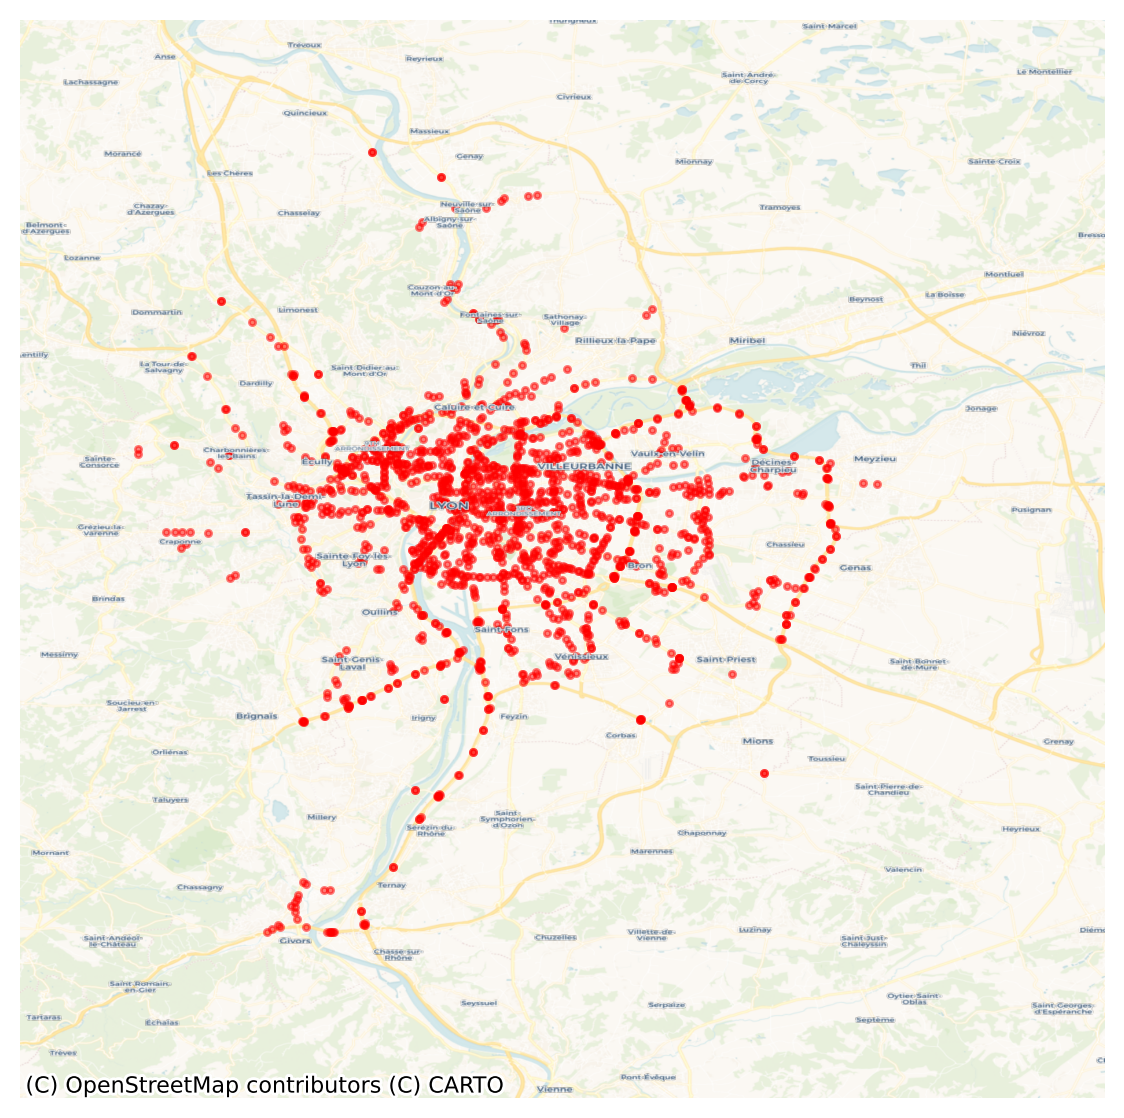

In [16]:
# Plot sensors
#plt.figure(figsize = (10,10), dpi = 300)

fig, ax = plt.subplots(figsize = (7,7), dpi = 200)
gdf.plot(ax=ax, color = 'r', markersize = 5, alpha = .5)
# Add context in backround
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')
plt.axis('auto')

# Map matching with OSM

In [17]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import points_matching

In [18]:
gdf.identifiantptm.unique().size

1713

In [19]:
gdf = points_matching(gdf)

City downloaded


 12%|█▏        | 203/1713 [00:01<00:13, 113.35it/s]

Value Error - No roads found nearby current index


 31%|███▏      | 538/1713 [00:04<00:10, 114.43it/s]

Value Error - No roads found nearby current index


 37%|███▋      | 629/1713 [00:05<00:09, 114.92it/s]

Value Error - No roads found nearby current index


 47%|████▋     | 809/1713 [00:06<00:08, 111.18it/s]

Value Error - No roads found nearby current index


100%|██████████| 1713/1713 [00:13<00:00, 125.99it/s]

We failed to match 4 sensors
...on a total of 1713 sensors


In [20]:
gdf[['raw_name', 'osm_name']].dropna().drop_duplicates()[:30]

,raw_name,osm_name
0,1_Berthelot_Servant_Mace,Avenue Berthelot
1,2_Berthelot_Garibaldi_Vienne,Avenue Berthelot
2,3_Berthelot_JeanGay_Tchecoslovaques,Avenue Berthelot
3,4_Jean XXIII_Bataille_Bastie,Boulevard Jean XXIII
4,5_Bastie _Jean XXIII_Alouettes,Rue Maryse Bastié
5,6_Jean XXIII_Bastie_Bataille,Boulevard Jean XXIII
6,7_Rockfeller_Voiney_Arsonval,Avenue Rockefeller
7,8_Rockfeller_Eugenie_Pinel,Avenue Rockefeller
8,9_Rockfeller_Pinel_Eugenie,Avenue Rockefeller
9,10_Roosevelt_Tassigny_Lacroix,Avenue Franklin Roosevelt


In [21]:
gdf[gdf.osmid.isna()]
# Far away or living street / pedestrian

,identifiantptm,year,AAWT,raw_name,raw_lanes,geometry,osm_name,osm_type,osm_lanes,osm_oneway,osm_distance,osm_maxspeed,osmid
191,243,2023.0,32908.0,243_Garnier_Frenkel_Jaures,2,POINT (4.83284 45.72658),NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,697,2023.0,32136.0,697_INT_Quai_Bellevue,2,POINT (4.85548 45.78792),NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,847,2021.0,2327.0,847_Charlemagne_Riboud_Montrochet,1,POINT (4.81913 45.74083),NaN,NaN,NaN,NaN,NaN,NaN,NaN
785,1061,2023.0,32936.0,1061_Garnier_Gerland_Frenkel,2,POINT (4.83729 45.72627),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
from validate_dataset import validate_dataset

gdf = validate_dataset(gdf)

Number of NaN values for AAWT: 0
Number of NaN values for geometry: 0
Number of low outliers for AAWT: 0
Number of high outliers for AAWT: 10


# Final saving

In [33]:
# Saving
for year in gdf.year.unique() :
    # Extract corresponding year
    sub = gdf[gdf.year == year]
    print(year, sub.shape[0])
    sub[[
        'AAWT', 'geometry', 'raw_name', 'raw_lanes', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance', 'osm_maxspeed', 'osmid'
        ]].to_file(f'treated/Lyon_AAWT_{int(year)}.geojson')

2023.0 1596
2022.0 65
2019.0 12
2021.0 19
2020.0 11
